# Amazon.com - Employee Access Challenge


## Frame the Problem

- The given problem is related with time wasted in granting and revoking access to the employee within company.  For employee to access any resources he/she needs prior permission i.e. access of that resource. The access granting and revoking process is manual, handled by superviso. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

- <b>Objective:</b> We have to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.


- <b>Data:</b> The data consists of real historical data collected from 2010 & 2011. Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees.

Test dataset (10 columns): The test set for which predictions should be made.  Each row asks whether an employee having the listed characteristics should have access to the listed resource.

Training dataset (10 columns): Each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval.
Following are the features present in the training dataset:
- ACTION: Target variable. ACTION is 1 if the resource was approved, 0 if the resource was not approved.
- RESOURCE: An ID for each resource
- MGR_ID: The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time
- ROLE_ROLLUP_1: Company role grouping category id 1 (e.g. US Engineering)
- ROLE_ROLLUP_2: Company role grouping category id 2 (e.g. US Retail)
- ROLE_DEPTNAME: Company role department name (e.g. Retail)
- ROLE_TITLE: Company role business title description (e.g. Senior Engineering Retail Manager)
- ROLE_FAMILY_DESC: Company role family extended description (e.g. Retail Manager, Software Engineering)
- ROLE_FAMILY: Company role family description (e.g. Retail Manager)
- ROLE_CODE: Company role code; this code is unique to each role (e.g. Manager)

All features has numerical values but all features are categorical features.
 


## Install Vectice and modules needed to connect to Google Cloud Storage(GCS)

Vectice provides a generic metadata layer that is potentially suitable for most data science workflows. For this tutorial we will use the sickit-learn library for modeling and track experiments directly through our Python SDK to illustrate how to fine-tune exactly what you would like to track: metrics, etc. The same mechanisms would apply to R, Java or even more generic REST APIs to track metadata from any programming language and library.

In [ ]:
## Requirements
!pip3 install fsspec
!pip3 install gcsfs
!pip3 install vectice

     |████████████████████████████████| 122kB 4.0MB/s 
     |████████████████████████████████| 1.3MB 4.4MB/s 
     |████████████████████████████████| 296kB 11.6MB/s 
     |████████████████████████████████| 143kB 12.4MB/s 
     |████████████████████████████████| 51kB 2.1MB/s 
     |████████████████████████████████| 174kB 5.8MB/s 
     |████████████████████████████████| 296kB 26.4MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 962kB 45.8MB/s 


In [ ]:
!pip3 show vectice

Name: vectice
Version: 0.0.6
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: GitPython, PyGithub, requests, python-dotenv
Required-by: 


## Import the required libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from vectice.models import JobType

import warnings
warnings.filterwarnings("ignore")

## Get the training and test data from GCS 

In [ ]:
# Load your json key file to access GCS that was provided with your tutorial account. 
# The name should be something like test.json.
from google.colab import files
uploaded = files.upload()

In [ ]:
# Once your file is loaded set the credentials for GCS and load the file
# in a pandas frame, double check the json file name you uploaded.

### Complete with the name of the file your json key file to access GCS that was provided with your tutorial account
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '

# The original source dataset is already declared in the Vectice UI as "amazon_employee_access_train",
# and its connection to "gs://test-vectice-storage/Hackathon/Teams/EU_Team_Amazon_Employee/Amazon_Challenge/data/" has been established.
#data = pd.read_csv('gs://test-vectice-storage/Hackathon/Teams/EU_Team_Amazon_Employee/Amazon_Challenge/data/amazon_employee_access_train1.csv')
data = pd.read_csv('gs://vectice_samples_asd123/amazon_employee_access_train.csv')
# Run head to make sure the data was loaded properly

data.head()

In [ ]:
data.shape

(32769, 10)

## Data Exploration

Data exploration enables us to take a first look on the data, can enhance the overall understanding of the characteristics of the data domain and helps to detect correlation between the features, thereby allowing for the creation of more accurate models

In [ ]:
data_explore = data.copy()

In [ ]:
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


There is no column with null values.

In [ ]:
data_explore.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

- In dataset description it is mention that an employee can have only one manager at a time, then we can consider that the dataset contains information of maximum 4243 employees.
- There are same number of unique values for ROLE_TITLE and ROLE_CODE. There is 1-to-1 mapping between these columns. So for our problem only one feature is sufficent.

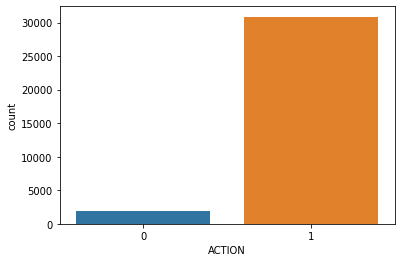

In [ ]:
sns.countplot(x='ACTION', data=data_explore)

In [ ]:
data['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

- We can see that we have an imbalanced dataset. There are very less records of not granting the access. some algorithms may learn just from the ones


In [ ]:
## Manager ID and how much resources he has access to
data['MGR_ID'].value_counts()

770      152
2270      99
2594      82
1350      71
2014      67
        ... 
1940       1
8087       1
22526      1
34948      1
58677      1
Name: MGR_ID, Length: 4243, dtype: int64

- Lets find out top 15 Resources, Role department, Role family, Role codes for which most access is requested.

In [ ]:
data_explore_resources = data_explore[['RESOURCE', "ACTION"]].groupby(by='RESOURCE').count()
data_explore_resources.sort_values('ACTION', ascending=False).head(n=15).transpose()

RESOURCE,4675,79092,25993,75078,3853,75834,6977,32270,42085,17308,1020,13878,42093,18418,7543
ACTION,839,484,409,409,404,299,299,295,247,239,236,220,204,192,186


In [ ]:
data_explore_role_dept = data_explore[['ROLE_DEPTNAME', "ACTION"]].groupby(by='ROLE_DEPTNAME').count()
data_explore_role_dept.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_DEPTNAME,117878,117941,117945,118514,117920,117884,119598,118403,119181,120722,118320,117895,118746,118783,120663
ACTION,1135,763,659,601,597,546,543,532,525,501,435,431,415,366,335


In [ ]:
data_explore_role_codes = data_explore[['ROLE_CODE', "ACTION"]].groupby(by='ROLE_CODE').count()
data_explore_role_codes.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_CODE,118322,117908,118786,117880,118570,117888,118055,118687,118779,118454,120346,118332,119082,117973,118425
ACTION,4649,3583,1772,1256,1043,806,774,597,566,521,473,467,394,384,376


In [ ]:
data_explore_role_family = data_explore[['ROLE_FAMILY', "ACTION"]].groupby(by='ROLE_FAMILY').count()
data_explore_role_family.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_FAMILY,290919,118424,19721,117887,292795,118398,308574,118453,118331,118643,118638,270488,118295,118960,118205
ACTION,10980,2690,2636,2400,1318,1294,1287,941,892,783,783,689,493,465,449


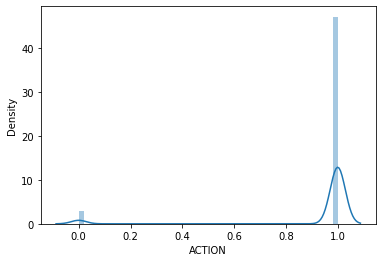

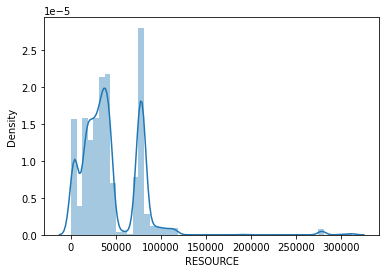

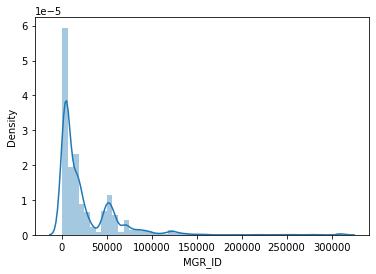

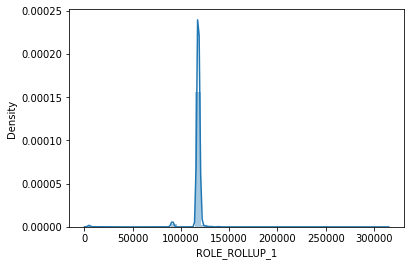

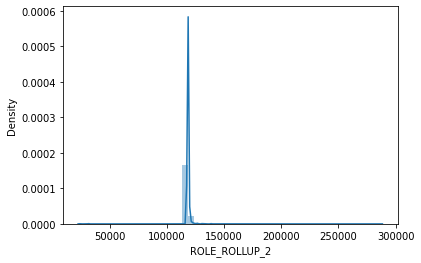

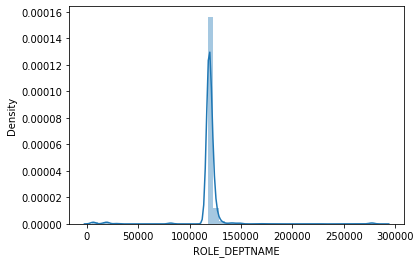

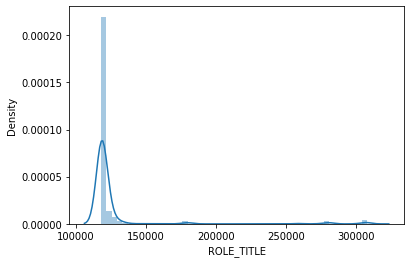

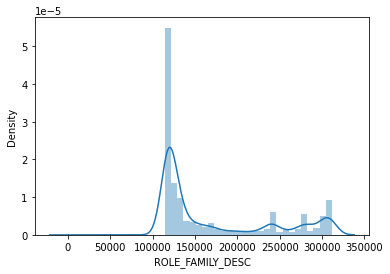

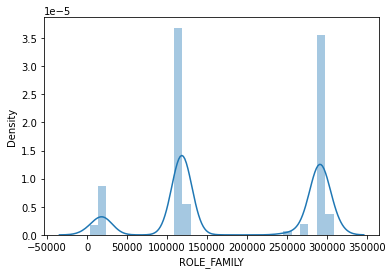

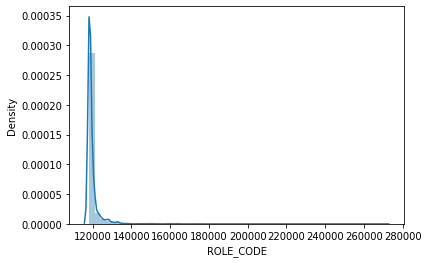

In [ ]:
## We use data.describe() to only take numerical columns ,and avoid non numerical ones, in order to plot them
for i in data.describe().columns:
  sns.distplot(data[i].dropna())
  plt.show()

### Correlation

If we have a big correlation, we have a problem of multicolinearity. That means that there are some features that depend of other features, so we should reduce the dimentionality of our data (if A depends of B, we should either find a way to aggregate or combine the two features and turn it into one variable or drop one of the variables that are too highly correlated with another) and that can be adressed using Principal component analysis (PCA)

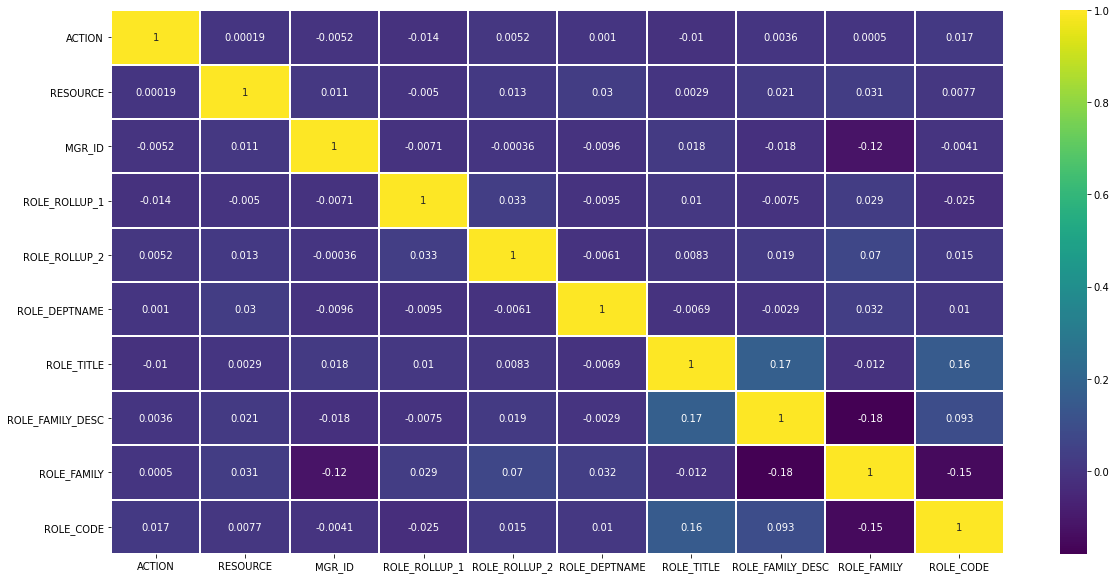

In [ ]:
## If we have a big correlation, we have a problem of multicolinearity that can be adressed using PCA
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),annot=True,cmap='viridis',linewidth=1)


In [ ]:
corr_matrix = data_explore.corr()
corr_matrix['ACTION'].sort_values(ascending=False)

ACTION              1.000000
ROLE_CODE           0.017147
ROLE_ROLLUP_2       0.005179
ROLE_FAMILY_DESC    0.003565
ROLE_DEPTNAME       0.001025
ROLE_FAMILY         0.000502
RESOURCE            0.000185
MGR_ID             -0.005167
ROLE_TITLE         -0.010169
ROLE_ROLLUP_1      -0.013702
Name: ACTION, dtype: float64

- There is no attribute to which target variable is strongly correlated.

## Connect to your Vectice workspace and your Vectice project

Here we are going to need an API token and a project token. An API token is used to secure requests between your existing tools and Vectice. You can create and manage those at the API Tokens tab in your workspace, and they impersonate you and your rights per workspace, so we strongly recommend you to avoid sharing them. A project token is used to target the project you're working on in the UI and can found (after creating a project) in the Project settings page, and anyone working on the project can see it and copy/paste it.

In [ ]:
# In order to use Vectice SDK, let's set up the configurations first.
# The Vectice API key below can be generated from the UI.
# For better security, the settings can also be put into a dedicated file called `.vectice` or `.env`.
## Make sure that you're using the right endpoint (hint: be-beta.vectice.com)
os.environ['VECTICE_API_ENDPOINT']= ""
os.environ['VECTICE_API_TOKEN'] = ""

## Create a Vetice instance to connect to your project using your project token
## Hint: Do not forget to import vectice (from vectice import Vectice)
vectice = ""

print(vectice)

In [ ]:
#@title Double click to show the syntax
#os.environ['VECTICE_API_ENDPOINT']= "be-beta.vectice.com"
os.environ['VECTICE_API_ENDPOINT']="be-test.vectice.com"
##Complete with your Vectice API token
os.environ['VECTICE_API_TOKEN'] = ""
from vectice import Vectice
## Complete with your project token
vectice = Vectice(project_token="")
print(vectice)

## Data Preprocessing

Data preprocessing alludes to the method of cleaning and arranging the crude data to make it appropriate for building and preparing AI models. Data preprocessing is a procedure that changes crude data into an instructive and lucid arrangement.

Our training data contains categorical data (information that is divided into groups, it could be numbers but without mathematical meaning like IDs). Thus, we should encode it or use algorithms that can deal with categorical data like CatBoost. If we don't preprocess this categorical data, some algorithms may learn false information. For example, an ID of 1000 would be considered as much greater than an ID of 1 which is not necessarily true. Thus we can use OneHotEncoder to before using algorithms on categorical data. One-hot encoding in machine learning is the conversion of categorical information into a format that may be fed into machine learning algorithms to improve prediction accuracy. It is a common method for dealing with categorical data in machine learning. Categorical variables must be changed in the pre-processing section since machine learning models require numeric input variables. Nominal or ordinal data can be found in categorical data. This approach creates a new column for each unique value in the original category column. The zeros and ones are subsequently put in these dummy variables (1 meaning TRUE, 0 meaning FALSE)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
X = data.drop(columns=['ACTION'], axis=1).copy()
y = data['ACTION'].copy()
X.shape, y.shape

In [ ]:
cat_attrs = list(X.columns)
cat_attrs

Create a dataset containing your dataset to use it as input for your splitting data job. That can be done through the UI by going to your project, clicking on datasets and then click on add (you should add a connection to be able to create a dataset)

Create a dataset version based on the dataset you created above

In [ ]:
input_ds_version = ""

In [ ]:
#@title Double click to show the syntax
# Use auto-versioning here
input_ds_version =  vectice.create_dataset_version().with_parent_name("dataset")

The following code splits the dataset to train and test sets. Please complete itwith creating PREPARATION job run, start it and then declare train_set and test_set as dataset versions (after creating the datasets in the UI) in order to be able to use them as inputs for the different models.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
  strat_train_set = data.iloc[train_index]
  strat_test_set = data.iloc[test_index]

X_train = strat_train_set.drop('ACTION', axis=1)
y_train = strat_train_set['ACTION'].copy()
X_test = strat_test_set.drop('ACTION', axis=1)
y_test = strat_test_set['ACTION'].copy()
X_train.shape, X_test.shape

train_set = X_train.join(y_train)
test_set = X_test.join(y_test)

In [ ]:
#@title Double click to show the answer
from sklearn.model_selection import StratifiedShuffleSplit

input_code = Vectice.create_code_version_with_github_uri("https://github.com/vectice/vectice-examples/Notebooks/Vanilla/Customer_satisfaction_example")
input_ds_version = input_ds_version

# Start a Vectice run. The job type should be PREPARATION in this case.

vectice.create_run("jobSplitData", JobType.PREPARATION)
with vectice.start_run(inputs=[input_ds_version, input_code]) as run:

  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

  for train_index, test_index in split.split(X, y):
      strat_train_set = data.iloc[train_index]
      strat_test_set = data.iloc[test_index]

  X_train = strat_train_set.drop('ACTION', axis=1)
  y_train = strat_train_set['ACTION'].copy()
  X_test = strat_test_set.drop('ACTION', axis=1)
  y_test = strat_test_set['ACTION'].copy()
  X_train.shape, X_test.shape

  train_set = X_train.join(y_train)
  test_set = X_test.join(y_test)
# We commented out the code to persist the training and testing test in GCS,
# because we already generated it for you, but feel free to uncomment it and execute it.
# The key you were provided for this tutorial may not have write permissions to GCS.
# Let us know if you want to be able to write files as well and we can issue you a different key.

  #train_set.to_csv (r'gs://vectice-examples-samples/Amazon_challenge/training_data.csv', index = False, header = True)
  #test_set.to_csv (r'gs://vectice-examples-samples/Amazon_challenge/testing_data.csv', index = False, header = True)

  # Don't forget to create the datasets in the UI before creating train_ds_version and test_ds_version 
  train_ds_version = vectice.create_dataset_version().with_parent_name("train_amazon_employee_access_challenge_dataset")
  test_ds_version = vectice.create_dataset_version().with_parent_name("test_amazon_employee_access_challenge_dataset")
  
  run.add_outputs([train_ds_version,test_ds_version])


We create a pipeline with the OneHotEncoder for algorithms that doesn't support categorical data

In [ ]:
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_enc', OneHotEncoder(handle_unknown='ignore'))])

pre_process = ColumnTransformer([('cat_process', cat_pipeline, cat_attrs)], remainder='passthrough')

X_train_transformed = pre_process.fit_transform(X_train)
X_test_transformed = pre_process.transform(X_test)
X_train_transformed.shape, X_test_transformed.shape

((26215, 14410), (6554, 14410))

- Since we will be using CatBoost Classifier. For CatBoost model, there is no need of encoding categorical model. Hence we will be creating a separate preprocessing pipeline for CatBoost model.

In [ ]:
cat_boost_pre_process = ColumnTransformer([('imputer', SimpleImputer(strategy='most_frequent'), cat_attrs)], remainder='passthrough')

X_cb_train_transformed = cat_boost_pre_process.fit_transform(X_train)
X_cb_test_transformed = cat_boost_pre_process.transform(X_test)
X_cb_train_transformed.shape, X_cb_test_transformed.shape

In [ ]:
feature_columns = list(pre_process.transformers_[0][1]['cat_enc'].get_feature_names(cat_attrs))
len(feature_columns)

14410

## Get different user versions

Generate a random user version by calling get_random_string


In [ ]:
# Let's generate some unique names for our following modeling experiments
import random
import string
def get_random_string(length):
    return "".join(random.choice(string.ascii_letters) for i in range(length))

rdm_str = get_random_string(5)
print("Generated random string to make job names unique:", rdm_str)


Generated random string to make job names unique: YErxD


## Modelling

- Evaluation metric for this competition is ROC AUC Score. Roc_auc_score : ROC curve is a graph that shows the performance of a classification model at all possible thresholds( threshold is a particular value beyond which you say a point belongs to a particular class). AUC measures how well a model is able to distinguish between classes. The curve is plotted between two parameters :
    * TRUE POSITIVE RATE
    * FALSE POSTIVIE RATE
- Since we have imbalance dataset, we will use Matthews correlation coefficient (MCC) as another evaluation metric. 
- Value of MCC is lies between -1 to +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
    - ${MCC} = \frac{(TP + TN) * (FP + FN)}{\sqrt{( (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN))}}$

     * True Positive (TP): The value of correct predictions of positives out of actual positive cases. Ex : Predict a well person as not sick
   * False Positive (FP): The value of incorrect positive predictions. The number of negatives falsly pridected as positives. Ex : Predict a sick person as not sick
  * True Negative (TN): The value of correct predictions of negatives out of actual negative cases. Ex : Predict a sick person as sick
  * False Negative (FN): The value of incorrect negative predictions. This value represents the number of positives which gets falsely. Predict a well person as sick
    
- MCC value will be high only if model has high accuracy on predictions of negative data instances as well as of positive data instances
- We will be selecting the best model with highest ROC AUC Score
- Here we use cross-validation which is a statistical method used to estimate the performance (or accuracy) of machine learning models and protect them from overfitting ((the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably)). The main idea of cross-validation is to make a fixed number of folds (or partitions) of the data, run the analysis on each fold, and then average the overall error estimate

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_auc_score, roc_curve
Matthew = make_scorer(matthews_corrcoef)

results = []

def plot_custom_roc_curve(clf_name, y_true, y_scores):
    auc_score = np.round(roc_auc_score(y_true, y_scores), 3)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=clf_name+" (AUC Score: {})".format(str(auc_score)))
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    plt.legend()
    
    
def performance_measures(model, X_tr=X_train_transformed, y_tr=y_train, X_ts=X_test_transformed, y_ts=y_test,
                         store_results=True):
    train_mcc = cross_val_score(model, X_tr, y_tr, scoring=Matthew, cv=kf, n_jobs=-1)
    test_mcc = cross_val_score(model, X_ts, y_ts, scoring=Matthew, cv=kf, n_jobs=-1)
    print("Mean Train MCC: {}\nMean Test MCC: {}".format(train_mcc.mean(), test_mcc.mean()))

    
    train_roc_auc = cross_val_score(model, X_tr, y_tr, scoring='roc_auc', cv=kf, n_jobs=-1)
    test_roc_auc = cross_val_score(model, X_ts, y_ts, scoring='roc_auc', cv=kf, n_jobs=-1)
    print("Mean Train ROC AUC Score: {}\nMean Test ROC AUC Score: {}".format(train_roc_auc.mean(), test_roc_auc.mean()))
    return train_mcc.mean(), test_mcc.mean(), train_roc_auc.mean(), test_roc_auc.mean()
    
    if store_results:
        results.append([model.__class__.__name__, np.round(np.mean(train_roc_auc), 3), np.round(np.mean(test_roc_auc), 3), np.round(np.mean(train_mcc), 3), np.round(np.mean(test_mcc), 3)])
    

    

In [ ]:
def plot_feature_importance(feature_columns, importance_values, top_n_features=10):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)
    
    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

### Logistic regression
Logistic regression is used to calculate the probability of a binary event occurring. For example, predicting if a credit card transaction is fraudulent or not fraudulent or predicting if an incoming email is spam or not spam

The following code creates a Logistic regression model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice (You can look at the examples in the documentation) and don't forget to use the names you generated for your experimints

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

# Create a run
# Start the run

logistic_reg = LogisticRegression(solver='liblinear', C=1, penalty='l2', max_iter=1000, random_state=42, n_jobs=-1)
logistic_reg.fit(X_train_transformed, y_train)
train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(logistic_reg)


## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)


In [ ]:
#@title Double click to show the answer
#Logistic Regression
from sklearn.linear_model import LogisticRegression

vectice.create_run(job_name = "Train with Logistic regression", job_type=JobType.TRAINING)
## We use with here to catch errors and put the run's statut as failed in the UI in case we encounter an error, else it ends the successful runs
with vectice.start_run(inputs=[train_ds_version,test_ds_version]) as run:
  solver='liblinear'
  C=1
  penalty='l2'
  max_iter=1000
  random_state=42
  n_jobs=-1
  logistic_reg = LogisticRegression(solver=solver, C=C, penalty=penalty, max_iter=max_iter, random_state=random_state, n_jobs=n_jobs)
  logistic_reg.fit(X_train_transformed, y_train)
  train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(logistic_reg)

  metrics = [("Train_mcc",train_mcc),("test_mcc",test_mcc), ("train_roc_auc", train_roc_auc), ('test_roc_auc', test_roc_auc)]
  properties = [("solver",solver), (C, C), ("penalty", penalty), ("max_iter", max_iter), ("random_state", random_state), ("n_jobs", n_jobs)]
  model_version = vectice.create_model_version().with_parent_name("Logistic Regression").with_properties(properties).with_metrics(metrics).with_user_version(get_random_string(12))
  ## .algorith_name
  run.add_outputs([model_version])

In [ ]:
plot_feature_importance(feature_columns, logistic_reg.coef_[0], top_n_features=15)

In [ ]:
train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(logistic_reg)

### Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. A decision tree is a type of flowchart that shows a clear pathway to a decision. A decision tree starts at a single point (or ‘node’) which then branches (or ‘splits’) in two or more directions going all the way to the leaves that give the decisions

The following code creates a Random Forest model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice (You can look at the examples in the documentation) and don't forget to use the names you generated for your experimints

In [ ]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier

#Create a run
# Start the run
forest_clf = RandomForestClassifier(n_estimators=300, max_depth=16, random_state=42,n_jobs=-1)
forest_clf.fit(X_train_transformed, y_train)

train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(forest_clf)

## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)


In [ ]:
#@title Double click to show the code
from sklearn.ensemble import RandomForestClassifier

vectice.create_run(job_name = "Training Random Forest", job_type=JobType.TRAINING)
## We use with here to catch errors and put the run's statut as failed in the UI in case we encounter an error, else it ends the successful runs
with vectice.start_run(inputs=[train_ds_version,test_ds_version]) as run:
  n_estimators=300
  max_depth=16
  random_state=42
  n_jobs=-1

  forest_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state,n_jobs=n_jobs)
  forest_clf.fit(X_train_transformed, y_train)

  train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(forest_clf)

  metrics = [("Train_mcc",train_mcc),("test_mcc",test_mcc), ("train_roc_auc", train_roc_auc), ('test_roc_auc', test_roc_auc)]
  properties = [("n_estimators",n_estimators), ("max_depth", max_depth), ("random_state", random_state), ("n_jobs", n_jobs)]

  model_version1 = vectice.create_model_version().with_parent_name("Random Forest").with_properties(properties).with_metrics(metrics).with_user_version(get_random_string(12))
  run.add_outputs([model_version1])

Mean Train MCC: 0.0
Mean Test MCC: 0.0
Mean Train ROC AUC Score: 0.8165212108561294
Mean Test ROC AUC Score: 0.7437150686782488


In [ ]:
plot_feature_importance(feature_columns, forest_clf.feature_importances_, top_n_features=15)

In [ ]:
performance_measures(forest_clf)

###XGBoost
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way

The following code creates a XGBoost model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice (You can look at the examples in the documentation) and don't forget to use the names you generated for your experimints

In [ ]:
from xgboost import XGBClassifier

#Create a run
# Start the run

xgb_clf = XGBClassifier(n_estimators=300, max_depth=16, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_transformed, y_train)

train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(xgb_clf)

## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)
## End the run

In [ ]:
#@title Double click to show the answer
from xgboost import XGBClassifier

vectice.create_run(job_name = "Training with XGBClassifier", job_type=JobType.TRAINING)
## We use with here to catch errors and put the run's statut as failed in the UI in case we encounter an error, else it ends the successful runs
with vectice.start_run(inputs=[train_ds_version,test_ds_version]) as run:
  n_estimators=300
  max_depth=16
  learning_rate=0.1
  random_state=42
  n_jobs=-1

  xgb_clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state, n_jobs=n_jobs)
  xgb_clf.fit(X_train_transformed, y_train)

  train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(xgb_clf)
  properties = [("n_estimators",n_estimators), ("max_depth", max_depth), ("learning_rate", learning_rate), ("random_state", random_state), ("n_jobs", n_jobs)]

  metrics = [("Train_mcc",train_mcc),("test_mcc",test_mcc), ("train_roc_auc", train_roc_auc), ('test_roc_auc', test_roc_auc)]

  model_version2 = vectice.create_model_version().with_parent_name("XGBoost").with_properties(properties).with_metrics(metrics).with_user_version(get_random_string(12))

  run.add_outputs([model_version2])

In [ ]:
plot_feature_importance(feature_columns, xgb_clf.feature_importances_, top_n_features=15)

In [ ]:
performance_measures(xgb_clf)

### Catboost

Catboost is a boosted decision tree machine learning algorithm. It works in the same way as other gradient boosted algorithms such as XGBoost but provides support out of the box for categorical variables, has a higher level of accuracy without tuning parameters and also offers GPU support to speed up training.

In [ ]:
!pip install catboost

The following code creates a Catboost model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice (You can look at the examples in the documentation) and don't forget to use the names you generated for your experimints

In [ ]:
from catboost import CatBoostClassifier

#Create a run
#Start the run

catboost_clf = CatBoostClassifier(loss_function='Logloss', iterations=500, depth=6, l2_leaf_reg=1, 
                                  cat_features=list(range(X_cb_train_transformed.shape[1])), 
                                  eval_metric='AUC', random_state=42, verbose=0)
catboost_clf.fit(X_cb_train_transformed, y_train)


train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(catboost_clf, X_tr=X_cb_train_transformed, X_ts=X_cb_test_transformed)

## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)


In [ ]:
#@title Double click to show the answer
from catboost import CatBoostClassifier

vectice.create_run(job_name = "Training with CatBoost", job_type=JobType.TRAINING)
## We use with here to catch errors and put the run's statut as failed in the UI in case we encounter an error, else it ends the successful runs
with vectice.start_run(inputs=[train_ds_version,test_ds_version]) as run:
  loss_function='Logloss'
  iterations=500
  depth=6
  eval_metric='AUC'
  l2_leaf_reg=1
  random_state=42
  verbose=0
  cat_features=list(range(X_cb_train_transformed.shape[1]))
  catboost_clf = CatBoostClassifier(loss_function=loss_function, iterations=iterations, depth=depth, l2_leaf_reg=l2_leaf_reg, 
                                    cat_features=cat_features, 
                                    eval_metric=eval_metric, random_state=random_state, verbose=verbose)
  catboost_clf.fit(X_cb_train_transformed, y_train)

  train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(catboost_clf, X_tr=X_cb_train_transformed, X_ts=X_cb_test_transformed)

  metrics = [("Train_mcc",train_mcc),("test_mcc",test_mcc), ("train_roc_auc", train_roc_auc), ('test_roc_auc', test_roc_auc)]
  properties = [("loss_function",loss_function), ("iterations", iterations), ("categorical features",list(range(X_cb_train_transformed.shape[1]))),
                ("verbose",verbose), ("depth", depth), ("eval_metric", eval_metric), ("l2_leaf_reg", l2_leaf_reg), ("random_state", random_state)]
  model_version3 = vectice.create_model_version().with_parent_name("CatBoost").with_properties(properties).with_metrics(metrics).with_user_version(get_random_string(12))
  run.add_outputs([model_version3])

In [ ]:
performance_measures(catboost_clf, X_tr=X_cb_train_transformed, X_ts=X_cb_test_transformed)

In [ ]:
plot_feature_importance(feature_columns, catboost_clf.feature_importances_, top_n_features=15)

###Voting classifier

A voting classifier is a classification method that employs multiple classifiers to make predictions. It is very applicable in situations when a data scientist or machine learning engineer is confused about which classification method to use. Therefore, using the predictions from multiple classifiers, the voting classifier makes predictions based on the most frequent one. It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

The following code creates a Voting classifier model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice (You can look at the examples in the documentation) and don't forget to use the names you generated for your experimints

In [ ]:
from sklearn.ensemble import VotingClassifier

#create a run
# Start the run

logistic_reg_pipeline = Pipeline([('pre_process', pre_process), ('logistic_reg', logistic_reg)])
forest_clf_pipeline = Pipeline([('pre_process', pre_process), ('forest_clf', forest_clf)])
xgb_clf_pipeline = Pipeline([('pre_process', pre_process), ('xgb_clf', xgb_clf)])
catboost_clf_pipeline = Pipeline([('pre_process', cat_boost_pre_process), ('catboost_clf', catboost_clf)])

named_estimators = [('logistic_reg', logistic_reg_pipeline), ('forest_clf', forest_clf_pipeline), 
                    ('xgb_clf', xgb_clf_pipeline), ('catboost_clf', catboost_clf_pipeline)]

voting_reg = VotingClassifier(estimators=named_estimators, voting='soft', n_jobs=-1)
voting_reg.fit(X_train, y_train)

train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(voting_reg, X_tr=X_train, X_ts=X_test)

## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)


In [ ]:
#@title Double click to show the answer
from sklearn.ensemble import VotingClassifier

vectice.create_run(job_name = "Training with Voting Classifier", job_type=JobType.TRAINING)
## We use with here to catch errors and put the run's statut as failed in the UI in case we encounter an error, else it ends the successful runs
with vectice.start_run(inputs=[train_ds_version,test_ds_version]) as run:
  logistic_reg_pipeline = Pipeline([('pre_process', pre_process), ('logistic_reg', logistic_reg)])
  forest_clf_pipeline = Pipeline([('pre_process', pre_process), ('forest_clf', forest_clf)])
  xgb_clf_pipeline = Pipeline([('pre_process', pre_process), ('xgb_clf', xgb_clf)])
  catboost_clf_pipeline = Pipeline([('pre_process', cat_boost_pre_process), ('catboost_clf', catboost_clf)])

  voting='soft'
  n_jobs=-1

  named_estimators = [('logistic_reg', logistic_reg_pipeline), ('forest_clf', forest_clf_pipeline), 
                      ('xgb_clf', xgb_clf_pipeline), ('catboost_clf', catboost_clf_pipeline)]

  voting_reg = VotingClassifier(estimators=named_estimators, voting=voting, n_jobs)
  voting_reg.fit(X_train, y_train)
  plot(named_estimators)
  train_mcc, test_mcc, train_roc_auc, test_roc_auc = performance_measures(voting_reg, X_tr=X_train, X_ts=X_test)

  metrics = [("Train_mcc",train_mcc),("test_mcc",test_mcc), ("train_roc_auc", train_roc_auc), ('test_roc_auc', test_roc_auc)]
  properties = [('voting', voting), ('n_jobs', n_jobs)]

  model_version4 = vectice.create_model_version().with_parent_name("VotingClassifier").with_properties(properties).with_metrics(metrics).with_user_version(get_random_string(12))

  run.add_outputs([model_version3])

In [ ]:
performance_measures(voting_reg, X_tr=X_train, X_ts=X_test)

## Model Evaluation

In [ ]:
result_df = pd.DataFrame(results, columns=['Model', 'CV Train AUC Score', 'CV Test AUC Score', 'CV Train MCC', 'CV Test MCC'])
result_df

In [ ]:
plt.figure(figsize=(8, 5))
plot_custom_roc_curve('Logistic Regression', y_test, logistic_reg.decision_function(X_test_transformed))
plot_custom_roc_curve('Random Forest', y_test, forest_clf.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('XGBoost', y_test, xgb_clf.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('CatBoost', y_test, catboost_clf.predict_proba(X_cb_test_transformed)[:,1])
plot_custom_roc_curve('Soft Voting', y_test, voting_reg.predict_proba(X_test)[:,1])
plt.show()